In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from matplotlib.patches import Rectangle  


In [8]:
csv_file_path = 'data_6_channels_train.csv'  
df = pd.read_csv(csv_file_path, header=0)

In [9]:

# NDVI: Index für "Greeness" zzwischen -1 und 1
# > 0.3 bis +1: Gesunde Vegetation (je höher, desto grüner/dichter). 
df['NDVI'] = (df['NIR'] - df['RED']) / (df['NIR'] + df['RED'])

# NBR: Index für Trockenheit/Brandflächen zwischen -1 und +1
# -0.1 bis +0.1: Trockene/Brandflächen (SWIR dominiert).
#-1 bis -0.2: Wasser/Schatten (niedrige Reflexion in NIR und SWIR)
df['NBR'] = (df['NIR'] - df['SW2']) / (df['NIR'] + df['SW2'])

# Veränderung der NBR (Brandstärke) siehe: https://un-spider.org/sites/default/files/table+legend.PNG
df["dNBR"] = df["NBR"].shift(1) - df["NBR"]

bins = [-float("inf"), -0.251, -0.101, 0.099, 0.269, 0.439, 0.659, float("inf")]
labels = [
    "Enhanced Regrowth, high (post-fire)",
    "Enhanced Regrowth, low (post-fire)",
    "Unburned",
    "Low Severity",
    "Moderate-low Severity",
    "Moderate-high Severity",
    "High Severity"
]

# Kategorie-Spalte erstellen
df["Severity_Level"] = pd.cut(
    df["dNBR"],
    bins=bins,
    labels=labels,
    right=False  
)



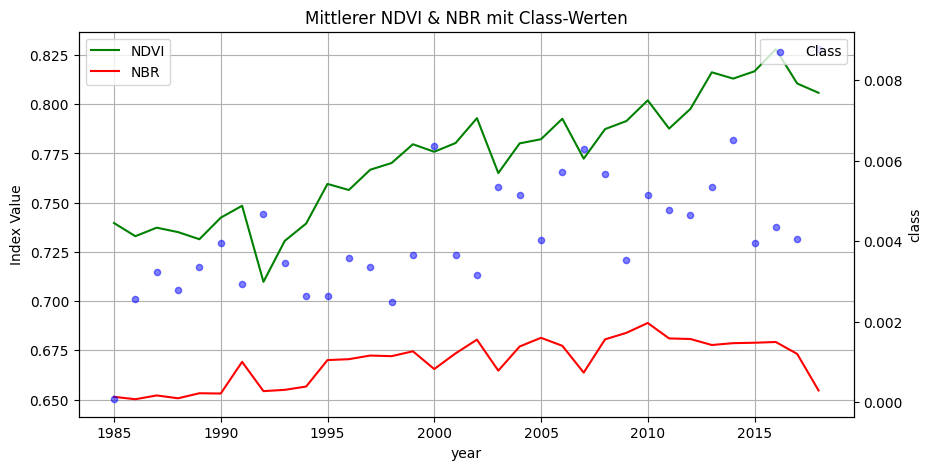

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Erste Achse für NDVI und NBR
ax1.set_title('Mittlerer NDVI & NBR mit Class-Werten')
ax1.set_xlabel('Year')
ax1.set_ylabel('Index Value')
df.groupby('year')['NDVI'].mean().plot(ax=ax1, color='green', label='NDVI')
df.groupby('year')['NBR'].mean().plot(ax=ax1, color='red', label='NBR')
ax1.legend(loc='upper left')
ax1.grid()

# Zweite Achse für Class-Werte
ax2 = ax1.twinx()
ax2.set_ylabel('Class Value')
mean_class_by_year.plot(x='year', y='class', kind='scatter', ax=ax2, color='blue', label='Class', alpha=0.5)
ax2.legend(loc='upper right')

plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_23268\1944216686.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_avg_class = df.groupby('Severity_Level')['class'].mean().reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_23268\1944216686.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=severity_avg_class, x='Severity_Level', y='class', palette='viridis')


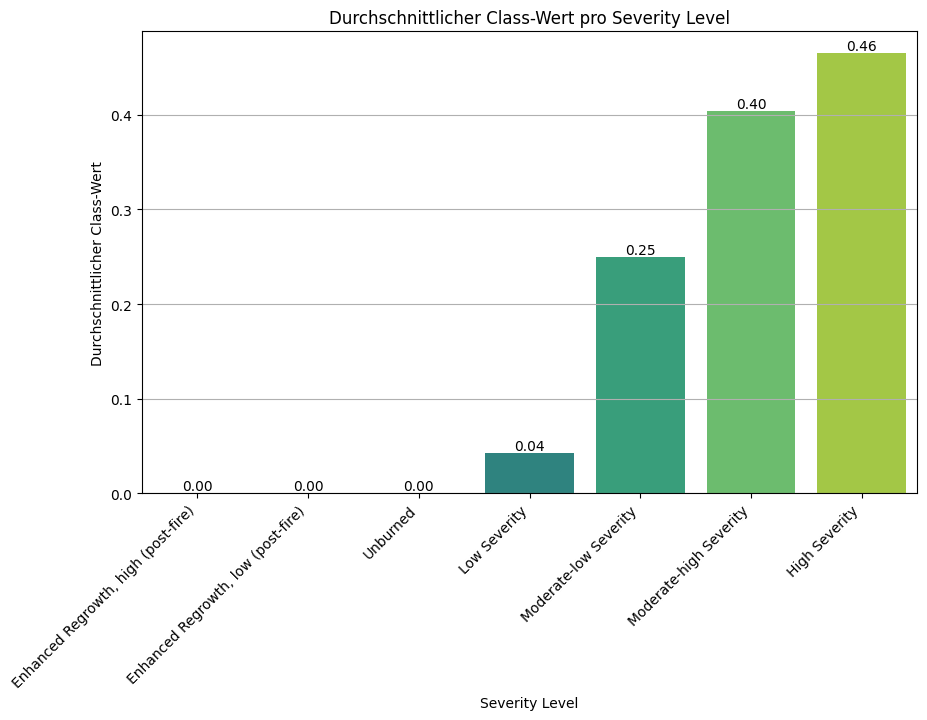

In [13]:
# Durchschnittliche class-Werte pro Severity_Level berechnen
severity_avg_class = df.groupby('Severity_Level')['class'].mean().reset_index()

# Barchart erstellen
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=severity_avg_class, x='Severity_Level', y='class', palette='viridis')

# Werte über den Balken anzeigen
for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), '.2f'),
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='bottom', fontsize=10)

plt.title('Durchschnittlicher Class-Wert pro Severity Level')
plt.xlabel('Severity Level')
plt.ylabel('Durchschnittlicher Class-Wert')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


In [24]:
# Korrelationsmatrix berechnen
correlation_matrix = df[['NBR', 'NDVI', 'class', 'SW1', 'BLU', 'GRN', 'RED', 'SW1', 'SW2', 'dNBR']].corr()

# Korrelationsmatrix anzeigen
print(correlation_matrix)

            NBR      NDVI     class       SW1       BLU       GRN       RED  \
NBR    1.000000  0.784853 -0.183733 -0.561793 -0.502528 -0.605613 -0.766324   
NDVI   0.784853  1.000000 -0.143868 -0.213656 -0.689029 -0.679028 -0.819992   
class -0.183733 -0.143868  1.000000  0.091558  0.083990  0.084442  0.128271   
SW1   -0.561793 -0.213656  0.091558  1.000000  0.465980  0.666585  0.643211   
BLU   -0.502528 -0.689029  0.083990  0.465980  1.000000  0.890559  0.847312   
GRN   -0.605613 -0.679028  0.084442  0.666585  0.890559  1.000000  0.935345   
RED   -0.766324 -0.819992  0.128271  0.643211  0.847312  0.935345  1.000000   
SW1   -0.561793 -0.213656  0.091558  1.000000  0.465980  0.666585  0.643211   
SW2   -0.821465 -0.500374  0.146890  0.900511  0.554684  0.740339  0.803491   
dNBR  -0.313599 -0.242459  0.262394  0.120401  0.165412  0.144141  0.207655   

            SW1       SW2      dNBR  
NBR   -0.561793 -0.821465 -0.313599  
NDVI  -0.213656 -0.500374 -0.242459  
class  0.091558 

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score

# Annahme: Daten werden in train_data und test_data aufgeteilt
train_data = df[df['year'] < 2015]  # Beispiel: Daten vor 2015 als Trainingsdaten
test_data = df[df['year'] >= 2015]  # Beispiel: Daten ab 2015 als Testdaten

# Time Series Split mit 5 Folds auf den Trainingsdaten
tscv = TimeSeriesSplit(n_splits=5)
f1_scores = []

for train_index, val_index in tscv.split(train_data):
    train_fold, val_fold = train_data.iloc[train_index], train_data.iloc[val_index]
    
    # Features und Zielvariable definieren
    X_train = train_fold[['NDVI', 'dNBR']]
    y_train = train_fold['class']
    X_val = val_fold[['NDVI', 'dNBR']]
    y_val = val_fold['class']
    
    # Decision Tree trainieren
    model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    # Vorhersagen auf den Validierungsdaten
    y_pred = model.predict(X_val)
    
# Testdaten vorbereiten
X_test = test_data[['NDVI', 'dNBR']]
y_test = test_data['class']

# Testdaten evaluieren
y_test_pred = model.predict(X_test)

# Precision, Recall und F1-Score berechnen
test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=1)
test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=1)
test_f1_score = f1_score(y_test, y_test_pred, average='binary', zero_division=1)

# Ergebnisse ausgeben
print(f"Precision auf den Testdaten: {test_precision:.4f}") 
print(f"Recall auf den Testdaten: {test_recall:.4f}") 
print(f"F1-Score auf den Testdaten: {test_f1_score:.4f}") # Verhältnis Precision (False Positive) & Recall (False Negative) 


Precision auf den Testdaten: 0.3101
Recall auf den Testdaten: 0.2237
F1-Score auf den Testdaten: 0.2599


In [ ]:
#Scores mit NBR und NDVI
#Precision auf den Testdaten: 0.0563
#Recall auf den Testdaten: 0.0365
#F1-Score auf den Testdaten: 0.0443

In [ ]:
#Scores mit dNBR und NDVI
#Precision auf den Testdaten: 0.3101
#Recall auf den Testdaten: 0.2237
#F1-Score auf den Testdaten: 0.2599
